In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
datasets = ["SDY67", "Monaco I", "Monaco II", "GSE65133", "GSE107572", "GSE120502"]
methods = ["MuSiC", "CibersortX", "Scaden", "TAPE-O", "TAPE-A", "Linear MLPs", "BayesPrism", "BayesPrism-M", "DISSECT"]

In [3]:
datadir = "data"
savedir = "plots"

if not os.path.exists(savedir):
    os.mkdir(savedir)

In [4]:
sns.set(style="whitegrid", font_scale=1.2)
color_palette = "colorblind"

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
# ignores FutureWarnings. Helps in readbility.
# Since we are using a conda envrionment with defined package versions we are not concerned with changes in a package's future releases.


# 2A

In [6]:
from scipy.spatial.distance import jensenshannon as jsd

In [7]:
def get_jsd(df1, df2):
    '''
    computes jensen shannon distance (JSD) between two dataframes.
    args
        df1: dataframe with ground truth proprotions (samples x celltypes) 
        df2: dataframe with predictions (samples x celltypes) 
    returns
        a list of JSDs for each sample in the dataframes
    '''
    df1 = df1[df2.columns]
    jsds = []
    for i in range(len(df1.index)):
        jsds.append(jsd(df1.iloc[i,:], df2.iloc[i,:]))

    return jsds

In [9]:
# compute for each sample for each method
jsds_dict = {}
for dataset in datasets:
    jsds_dict[dataset] = {}
    gt = pd.read_table(os.path.join(datadir, f"gt_{dataset}.txt"), index_col=0)
    celltypes = [col for col in gt.columns if col!="Unknown"]
    gt = gt.div(gt.sum(1), 0)
    for method in methods:
        if "Linear" not in method: # ignore linear method as it doesn't sum to 1
            tmp = pd.read_table(os.path.join(datadir, f"{method}_{dataset}.txt"), index_col=0)
            tmp = tmp[gt.columns]
            tmp = tmp.div(tmp.sum(1), 0)

            jsds_dict[dataset][method] = get_jsd(gt, tmp)
        

In [10]:
pal=sns.color_palette("colorblind", len(methods)+1) # 1 for linear MLPs
pal_hex = pal.as_hex()

In [11]:
pal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [12]:
print(pal_hex)

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [18]:
# store above list in colors
colors = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#ece133',  '#949494', '#fbafe4', ]


In [19]:
colors_dict = {}
i=0
methods1 = ["MuSiC", "CibersortX", "Scaden", "TAPE-O", "TAPE-A", "Linear MLPs", "BayesPrism", "BayesPrism-M", "DISSECT"]
for method in methods1:
    colors_dict[method] = colors[i]
    i+=1

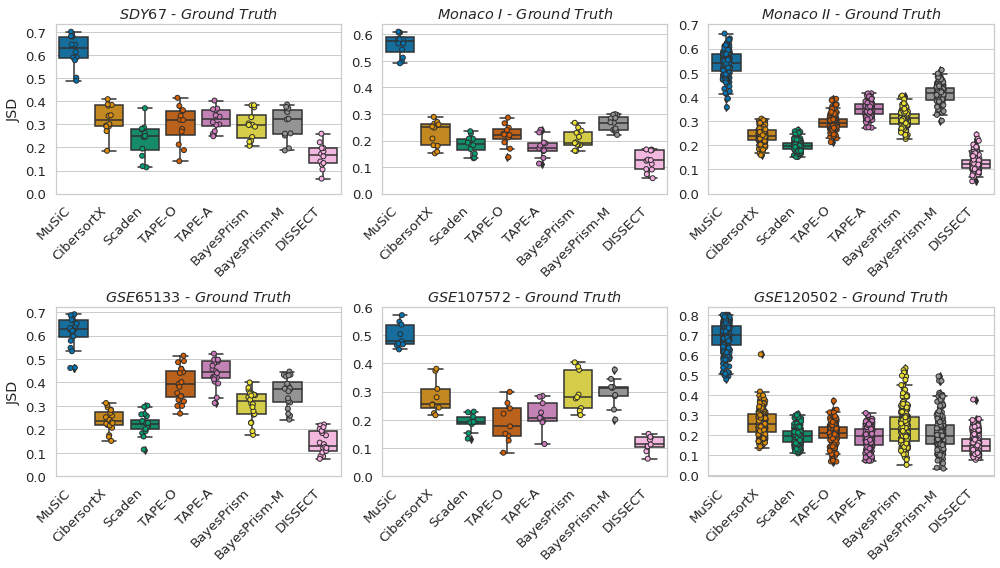

In [20]:
# Make boxplots
i=1
plt.figure(figsize=(14,8))

for dataset in jsds_dict:
    indices = list(range(len(jsds_dict[dataset]["MuSiC"])))
    df = pd.DataFrame(index=indices, columns=list(jsds_dict[dataset].keys()))
    for method in jsds_dict[dataset]:
        df[method] = jsds_dict[dataset][method]

    ax = plt.subplot(2,3,i)
    pd.DataFrame.iteritems = pd.DataFrame.items
    sns.boxplot(data=df, palette=colors_dict, ax=ax)
    sns.stripplot(data=df, palette=colors_dict, ax=ax, edgecolor="gray",
                 linewidth=1)
    plt.xticks(rotation=45, ha="right")
    if i==1 or i==4:
        # plt.ylabel(r"$JSD$")
        plt.ylabel("JSD")
        
    i+=1
    range_ = np.arange(0, df.max().max()+0.05, 0.1)
    
    if len(dataset.split(" "))>1:
        plt.title(r"${}$".format(dataset.split(" ")[0]) + " " \
                  + r"${}$".format(dataset.split(" ")[1]) + " - " + r"${}$".format("Ground") \
             + " " + r"${}$".format("Truth"))
    else:
        plt.title(r"${}$".format(dataset.split(" ")[0]) + " - " + r"${}$".format("Ground") \
             + " " + r"${}$".format("Truth"))
    plt.yticks(range_)
plt.tight_layout()

plt.savefig(os.path.join(savedir, "2A_jsd.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "2A_jsd.png"), bbox_inches="tight", dpi=300)

# 2B

In [21]:
def get_rmse(df1, df2, col):
    '''
    computes rmse between two vectors. 
    args
        df1: dataframe with ground truth proprotions (samples x celltypes) 
        df2: dataframe with predictions (samples x celltypes)
    returns
        rmse
    '''
    x, y = df1[col].tolist(), df2[col].tolist()
    rmse = mean_squared_error(x, y, squared=False)
    
    return rmse

In [22]:
import itertools
celltypes = ["Bcells", "CD4Tcells", "CD8Tcells", "Monocytes", "NK"]
# iterate over datasets and cell types to create a unique ID for each dataset-celltype pair
index=[e[0]+"_"+e[1] for e in list(itertools.product(datasets, celltypes+["Average"]))]

In [23]:
# compute for each dataset-cell type pair for each method
df1 = pd.DataFrame(index=index, columns=methods)
for celltype in ["Bcells", "CD4Tcells", "CD8Tcells", "Monocytes", "NK"]:
    if celltype!="Unknown":
        for dataset in datasets:
            gt = pd.read_table(os.path.join(datadir, f"gt_{dataset}.txt"), index_col=0)
            celltypes = [col for col in gt.columns if col!="Unknown"]
            gt = gt.div(gt.sum(1), 0)
            for method in methods:
                tmp = pd.read_table(os.path.join(datadir, f"{method}_{dataset}.txt"), index_col=0)
                tmp = tmp[gt.columns]
                tmp = tmp.div(tmp.sum(1), 0)
                df1.loc[dataset+"_"+celltype, method] = get_rmse(gt, tmp, celltype)


In [24]:
df1 = df1.reset_index()

In [25]:
df1["Dataset"] = [e.split("_")[0] for e in df1["index"]]
df1["Celltype"] = [e.split("_")[1] for e in df1["index"]]

In [26]:
df1 = df1.melt(id_vars=["Dataset", "index", "Celltype"])
df1.rename(columns={"variable": "Method", "value": "rmse"},
         inplace=True)

In [27]:
df1.index = [str(idx) for idx in df1.index]
for dataset in df1.Dataset.unique():
    for method in df1.Method.unique():
        sub = df1[(df1.Dataset==dataset)&(df1.Method==method)]
        mean_ = sub[sub.Celltype!="Average"].iloc[:,-1].mean()
        idx = sub[sub.Celltype=="Average"].index[0]
        df1.loc[idx, "rmse"] = sub.rmse.mean()

In [28]:
df1["c"] = df1["Dataset"]+"_"+df1["Method"]

In [29]:
# Get maximum suitably y-axis limit for better display
df1[["c", "rmse"]].groupby("c").agg("mean").max() # get max value for rmse average dataset-method

rmse    0.337709
dtype: object

In [44]:
colors_dict

{'MuSiC': '#0173b2',
 'CibersortX': '#de8f05',
 'Scaden': '#029e73',
 'TAPE-O': '#d55e00',
 'TAPE-A': '#cc78bc',
 'Linear MLPs': '#ca9161',
 'BayesPrism': '#ece133',
 'BayesPrism-M': '#949494',
 'DISSECT': '#fbafe4'}

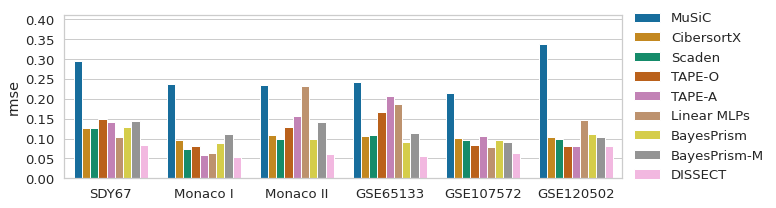

In [30]:
# Make barplots
plt.figure(figsize=(10,3))
sns.barplot(data=df1, hue="Method", x="Dataset", y="rmse",
           palette=colors_dict, ci=None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
# plt.ylabel(r"$rmse$")
plt.ylabel("rmse")
max_val=0.4 # close to 0.337709 computed above
plt.ylim(0,max_val+0.01)
plt.yticks(np.arange(0,max_val+0.01,0.05))
plt.xlabel("")
plt.savefig(os.path.join(savedir, "2B_average_rmse.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "2B_average_rmse.png"), bbox_inches="tight", dpi=300)


In [32]:
# print all
metric = "rmse"
df1 = df1[df1.Celltype!="Unknown"][["Dataset", "Method", metric]]
df1.groupby(["Dataset", "Method"]).agg("mean")

rmse
Dataset   Method                
GSE107572 BayesPrism    0.096789
          BayesPrism-M  0.092165
          CibersortX    0.102294
          DISSECT        0.06289
          Linear MLPs   0.078363
          MuSiC         0.215689
          Scaden        0.097166
          TAPE-A        0.105795
          TAPE-O        0.083075
GSE120502 BayesPrism    0.112283
          BayesPrism-M  0.104198
          CibersortX    0.104617
          DISSECT       0.081217
          Linear MLPs   0.146125
          MuSiC         0.337709
          Scaden        0.098611
          TAPE-A        0.081521
          TAPE-O        0.081368
GSE65133  BayesPrism    0.091441
          BayesPrism-M  0.115018
          CibersortX     0.10578
          DISSECT       0.055735
          Linear MLPs   0.186015
          MuSiC         0.242204
          Scaden        0.108521
          TAPE-A        0.205922
          TAPE-O        0.167108
Monaco I  BayesPrism    0.087847
          BayesPrism-M  0.112064
          CibersortX    0.096666
          DISSECT       0.053778
          Linear MLPs    0.06239
          MuSiC         0.236327
          Scaden        0.072792
          TAPE-A        0.058065
          TAPE-O        0.080036
Monaco II BayesPrism    0.097763
          BayesPrism-M  0.141368
          CibersortX    0.108274
          DISSECT       0.062002
          Linear MLPs   0.231639
          MuSiC         0.233858
          Scaden        0.099308
          TAPE-A        0.155726
          TAPE-O        0.129864
SDY67     BayesPrism    0.129345
          BayesPrism-M  0.144166
          CibersortX    0.125978
          DISSECT       0.084549
          Linear MLPs   0.103794
          MuSiC         0.294505
          Scaden        0.127007
          TAPE-A        0.142574
          TAPE-O        0.148558

# 2C

In [35]:
def get_corr(df1, df2, col):
    '''
    computes Pearson's r between two vectors. 
    args
        df1: dataframe with ground truth proprotions (samples x celltypes) 
        df2: dataframe with predictions (samples x celltypes) 
    returns
        pearson'r
    '''
    x, y = df1[col].tolist(), df2[col].tolist()
    r = np.corrcoef(x, y)[0,1]
    
    return r

In [36]:
import itertools
celltypes = ["Bcells", "CD4Tcells", "CD8Tcells", "Monocytes", "NK"]
# iterate over datasets and cell types to create a unique ID for each dataset-celltype pair
index=[e[0]+"_"+e[1] for e in list(itertools.product(datasets, celltypes+["Average"]))]

**Calculation of Pearson's r can lead to runtime (due to standard deviation being 0 for sample results, and as such variance is ill-defined which results in nan r). This warning can be ignored by running the following.**

In [37]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [38]:
# compute for each dataset-cell type pair for each method
df1 = pd.DataFrame(index=index, columns=methods)
for celltype in celltypes:
    if celltype!="Unknown":
        for dataset in datasets:
            gt = pd.read_table(os.path.join(datadir, f"gt_{dataset}.txt"), index_col=0)
            celltypes = [col for col in gt.columns if col!="Unknown"]
            gt = gt.div(gt.sum(1), 0)
            for method in methods:
                tmp = pd.read_table(os.path.join(datadir, f"{method}_{dataset}.txt"), index_col=0)
                tmp = tmp[gt.columns]
                tmp = tmp.div(tmp.sum(1), 0)
                df1.loc[dataset+"_"+celltype, method] = get_corr(gt, tmp, celltype)

In [39]:
# reset the index to split dataset and cell type names
df1 = df1.reset_index() 
df1["Dataset"] = [e.split("_")[0] for e in df1["index"]]
df1["Celltype"] = [e.split("_")[1] for e in df1["index"]]

In [40]:
# melt dataframe to long form suitable for Seaborn
df1 = df1.melt(id_vars=["Dataset", "index", "Celltype"])
df1.rename(columns={"variable": "Method", "value": "r"},
         inplace=True)

In [41]:
# compute averages
df1.index = [str(idx) for idx in df1.index]
for dataset in df1.Dataset.unique():
    for method in df1.Method.unique():
        sub = df1[(df1.Dataset==dataset)&(df1.Method==method)]
        mean_ = sub[sub.Celltype!="Average"].iloc[:,-1].mean()
        idx = sub[sub.Celltype=="Average"].index[0]
        df1.loc[idx, sub.columns[-1]] = mean_

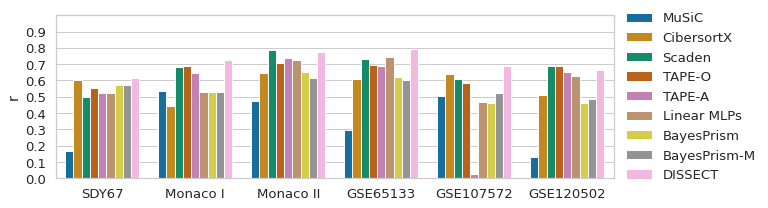

In [42]:
# Make barplot
plt.figure(figsize=(10,3))
sns.barplot(data=df1, hue="Method", x="Dataset", y="r", palette=colors_dict, ci=None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
# plt.ylabel(r"$r$")
plt.ylabel("r")
plt.ylim(0,1)
plt.yticks(np.arange(0,1,0.1))

plt.xlabel("")
plt.savefig(os.path.join(savedir, "2C_average_r.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "2C_average_r.png"), bbox_inches="tight", dpi=300)

In [43]:
# print all
metric = "r"
df1 = df1[["Dataset", "Method", metric]]
df1.groupby(["Dataset", "Method"]).agg("mean")

r
Dataset   Method                
GSE107572 BayesPrism    0.459318
          BayesPrism-M  0.522394
          CibersortX    0.638325
          DISSECT       0.691536
          Linear MLPs   0.469445
          MuSiC         0.505512
          Scaden         0.60842
          TAPE-A        0.027703
          TAPE-O        0.584371
GSE120502 BayesPrism    0.459385
          BayesPrism-M  0.486017
          CibersortX     0.51191
          DISSECT       0.663465
          Linear MLPs   0.626305
          MuSiC         0.129509
          Scaden         0.68918
          TAPE-A        0.654099
          TAPE-O        0.691665
GSE65133  BayesPrism    0.621939
          BayesPrism-M  0.605643
          CibersortX    0.608154
          DISSECT       0.792122
          Linear MLPs   0.745979
          MuSiC           0.2934
          Scaden        0.729442
          TAPE-A        0.690169
          TAPE-O        0.693723
Monaco I  BayesPrism    0.528906
          BayesPrism-M  0.532135
          CibersortX    0.445439
          DISSECT       0.723205
          Linear MLPs   0.527594
          MuSiC         0.537191
          Scaden        0.681931
          TAPE-A        0.644016
          TAPE-O        0.686817
Monaco II BayesPrism     0.65155
          BayesPrism-M  0.617435
          CibersortX    0.646067
          DISSECT       0.777325
          Linear MLPs   0.722698
          MuSiC         0.472584
          Scaden        0.788383
          TAPE-A        0.738919
          TAPE-O        0.708102
SDY67     BayesPrism    0.572448
          BayesPrism-M  0.573373
          CibersortX    0.600398
          DISSECT       0.616785
          Linear MLPs   0.521048
          MuSiC         0.168183
          Scaden        0.498971
          TAPE-A        0.520764
          TAPE-O        0.551779